# Inside Airbnb 2022 (4 Jan 2022)

### Importing Packages
**Here, I am taking the main packages from throughout the practicals as well as some of the functions from FSDS**

Work breakdown:
* Matthew Martignoni: Cleaning and NLP
* Phil: Spatial Autocorrelation

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
# This is the Cache Function Jon wrote
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [3]:
# This is the Plotting Function Jon wrote
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

In [4]:
# These are specific to NLP
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

In [5]:
#This is used in NLP to convert string object to be compatible with markdown
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

### Reading in the Data

In [6]:
listings2022 = pd.read_csv('listings.csv.gz', compression='gzip', low_memory=False)
print(f"Data frame is {listings2022.shape[0]:,} x {listings2022.shape[1]}")

Data frame is 69,351 x 75


In [7]:
# adding the borough data for maps
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


### General Data Cleaning: Booleans, Dates, Categories, Price Strings, Geography
**Most of this code comes from practical 5**

**In this section, I clean the entire dataset before selecting specific columns. This is for the purpose of reproducibility; individuals can select other fields in the Inside Airbnb dataset to expand upon this analysis.**


In [8]:
# Here I am parametrising the data by defining the columns so I can work with them more easily. This comes from the FSDS practical 5.
cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 
        'host_since', 'host_location', 'host_about', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'license', 'reviews_per_month', 'has_availability', 'calendar_last_scraped']

#### Booleans

In [9]:
# columns that seem to have values that should be booleans
bcols = ['instant_bookable', 'host_has_profile_pic', 'host_identity_verified','host_is_superhost', 'has_availability']

In [10]:
# Here I want to find which columsn have t/f as a value and should be booleans, check how to do this because I just went into the excel doc
#listings2022.filter(regex=("t"))

In [11]:
# I want to make the dataset more usable and storable so I'll convert certain columns to booleans
for b in bcols:
    print(f"Converting {b}")
    listings2022[b] = listings2022[b].replace({'f':False, 't':True}).astype('bool')

Converting instant_bookable
Converting host_has_profile_pic
Converting host_identity_verified
Converting host_is_superhost
Converting has_availability


In [12]:
print(listings2022.has_availability.dtype)
#all seem to be booleans but idk why that didn't improve the memory

bool


In [13]:
shm = listings2022.host_is_superhost.memory_usage(deep=True) # Super Host Memory
bhm = listings2022.host_is_superhost.replace({'f':False, 't':True}).astype('bool').memory_usage(deep=True) # Boolean Host Memory

print(f"The raw memory usage of `host_is_superhost` is {shm/1000:,.0f} Kb.")
print(f"The boolean memory usage of `host_is_superhost` is {bhm/1000:,.0f} Kb.")
print(f"That's {(bhm/shm)*100:.0f}% of the original!")

The raw memory usage of `host_is_superhost` is 69 Kb.
The boolean memory usage of `host_is_superhost` is 69 Kb.
That's 100% of the original!


In [14]:
listings2022.sample(5, random_state=43)[bcols]

,instant_bookable,host_has_profile_pic,host_identity_verified,host_is_superhost,has_availability
17512,True,True,True,False,True
51224,False,True,True,False,True
788,False,True,False,False,True
24782,True,True,True,False,True
18992,False,True,True,False,True


#### Dates

In [15]:
dates = ['last_scraped','host_since', 'calendar_last_scraped','first_review','last_review']
listings2022.sample(5, random_state=43)[dates]

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
17512,2022-09-11,2014-04-29,2022-09-11,2017-07-01,2017-09-05
51224,2022-09-11,2015-05-21,2022-09-11,2021-11-12,2021-11-12
788,2022-09-11,2012-07-13,2022-09-11,NaN,NaN
24782,2022-09-11,2015-09-04,2022-09-11,2018-06-02,2022-07-04
18992,2022-09-11,2014-06-08,2022-09-11,2017-08-17,2022-08-17


In [16]:
for d in dates:
    print("Converting " + d)
    listings2022[d] = pd.to_datetime(listings2022[d], infer_datetime_format=True)

Converting last_scraped
Converting host_since
Converting calendar_last_scraped
Converting first_review
Converting last_review


In [17]:
# This checks that we successfully changed the dates for each
for d in dates:
    print(listings2022[d].dtype, "\n")
    print(listings2022.sample(5, random_state=45)[d].dt.strftime('%A %B %d, %Y'))

datetime64[ns] 

10125    Sunday September 11, 2022
61320    Sunday September 11, 2022
49096    Monday September 12, 2022
36687    Monday September 12, 2022
6747     Sunday September 11, 2022
Name: last_scraped, dtype: object
datetime64[ns] 

10125         Monday March 11, 2013
61320     Tuesday November 17, 2009
49096          Tuesday May 03, 2016
36687    Tuesday September 06, 2016
6747      Wednesday August 12, 2015
Name: host_since, dtype: object
datetime64[ns] 

10125    Sunday September 11, 2022
61320    Sunday September 11, 2022
49096    Monday September 12, 2022
36687    Monday September 12, 2022
6747     Sunday September 11, 2022
Name: calendar_last_scraped, dtype: object
datetime64[ns] 

10125    Wednesday November 23, 2016
61320                            NaN
49096           Sunday July 04, 2021
36687         Saturday July 06, 2019
6747                             NaN
Name: first_review, dtype: object
datetime64[ns] 

10125    Tuesday September 06, 2022
61320                

#### Categories

In [18]:
# converting to categories, here I am selecting the columns that use categorical data so we can groupby better
cats = ['property_type','room_type', 'host_location', 'host_response_time', 'host_location', 'neighbourhood_cleansed']
listings2022.sample(5, random_state=42)[cats]

,property_type,room_type,host_location,host_response_time,host_location,neighbourhood_cleansed
26643,Private room in rental unit,Private room,"London, United Kingdom",NaN,"London, United Kingdom",Tower Hamlets
15713,Entire rental unit,Entire home/apt,"London, United Kingdom",within an hour,"London, United Kingdom",Westminster
67606,Entire home,Entire home/apt,"London, United Kingdom",NaN,"London, United Kingdom",Croydon
40703,Entire rental unit,Entire home/apt,"England, United Kingdom",NaN,"England, United Kingdom",Kensington and Chelsea
625,Entire rental unit,Entire home/apt,"London, United Kingdom",NaN,"London, United Kingdom",Kensington and Chelsea


In [19]:
listings2022[cats[0]].value_counts()

Entire rental unit             22780
Private room in rental unit    12133
Entire condo                    8676
Private room in home            8500
Entire home                     5379
                               ...  
Shared room in earthen home        1
Shared room in villa               1
Yurt                               1
Shared room in bus                 1
Bus                                1
Name: property_type, Length: 100, dtype: int64

In [20]:
for c in cats:
    print(f"Converting {c}")
    listings2022[c] = listings2022[c].astype('category')

Converting property_type
Converting room_type
Converting host_location
Converting host_response_time
Converting host_location
Converting neighbourhood_cleansed


In [21]:
print(listings2022[cats[3]].cat.categories.values)

['a few days or more' 'within a day' 'within a few hours' 'within an hour']


#### Price and String Values

In [22]:
money = ['price']
listings2022.sample(10, random_state=42)[money]

,price
26643,$22.00
15713,$450.00
67606,$175.00
40703,$214.00
625,$50.00
21460,$80.00
16731,$125.00
60779,$154.00
6370,$45.00
48603,$145.00


In [23]:
for m in money:
    print(f"Converting {m}")
    listings2022[m] = listings2022[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')
# part of the issue here was that you had to remove the commas as well because it wouldn't convert to a float if you just removed the $

Converting price


In [24]:
print(listings2022.price.dtype)

float64


In [25]:
print(len(listings2022[listings2022['price'] == 0]))

19


In [26]:
listings2022.price.describe()

count   69,351.00
mean       177.21
std        412.82
min          0.00
25%         55.00
50%        100.00
75%        180.00
max     25,000.00
Name: price, dtype: float64

Text(0, 0.5, 'Listing Count')

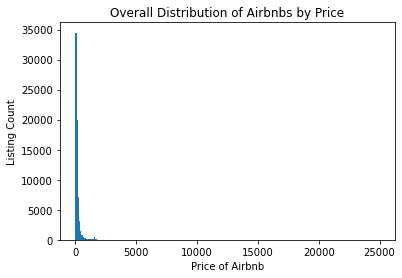

In [27]:
#Histograms of all Price data to help us see the mean
listings2022.price.plot.hist(bins=250)
plt.title("Overall Distribution of Airbnbs by Price")
plt.xlabel('Price of Airbnb')
plt.ylabel('Listing Count')

Text(0, 0.5, 'Listing Count')

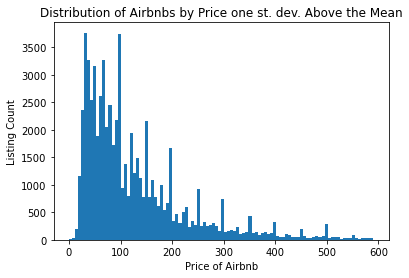

In [28]:
#Histogram of data 1 standard deviations above the mean
#listings2022_std = listings2022.price.drop(thresh=(177.21+(2*412.82)))
listings2022_std = listings2022[listings2022['price'] < (177.21+412.82)]


listings2022_std.price.plot.hist(bins= 100)
plt.title("Distribution of Airbnbs by Price one st. dev. Above the Mean")
plt.xlabel('Price of Airbnb')
plt.ylabel('Listing Count')

#### Converting other Values to Pandas Integers

In [29]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365']
for i in ints:
    print(f"Converting {i}")
    try:
        listings2022[i] = listings2022[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        listings2022[i] = listings2022[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting host_total_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting accommodates
Converting beds
  - !!!Converting to unsigned 16-bit integer!!!
Converting minimum_nights
Converting maximum_nights
Converting availability_365


#### Making the Longitude and Latitude in Geographically Usable Data

In [30]:
geo_listings2022 = gpd.GeoDataFrame(listings2022,geometry=gpd.points_from_xy(listings2022 .longitude, listings2022 .latitude, crs='epsg:4326'))
geo_listings2022.to_crs('epsg:27700')

#check the type
print(type(geo_listings2022))
print(type(geo_listings2022.geometry))
geo_listings2022.price.head

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>


<bound method NDFrame.head of 0        50.00
1        75.00
2        90.00
3        55.00
4       379.00
         ...  
69346    55.00
69347   201.00
69348   246.00
69349   250.00
69350   134.00
Name: price, Length: 69351, dtype: float64>

#### Exporting cleaned file

**This comes from practical 5 too. Undo the commenting out if you want to save these listings. The files are large and won't upload to github.

In [31]:
# Save general cleaned data
#listings2022.to_csv('2022listingsclean.csv')

In [32]:
# Save spatial cleaned data
#geo_listings2022.to_csv('geo_2022listingsclean.csv')

### NaNs and Nulls
**Here is potential code to identify null values in the whole dataset. However, we will not clean the null values yet because determining what to drop depends on the fields you intend to use for analysis.**

In [33]:
listings2022.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            69351 non-null  int64         
 1   listing_url                                   69351 non-null  object        
 2   scrape_id                                     69351 non-null  int64         
 3   last_scraped                                  69351 non-null  datetime64[ns]
 4   source                                        69351 non-null  object        
 5   name                                          69330 non-null  object        
 6   description                                   67832 non-null  object        
 7   neighborhood_overview                         39964 non-null  object        
 8   picture_url                                   69351 non-null  obje

In [34]:
#check for columns with most na values but here I will sort them in descending order to get a better visual sense
listings2022.isna().sum().sort_values(ascending=False).head(45)

calendar_updated                               69351
bathrooms                                      69351
neighbourhood_group_cleansed                   69351
license                                        69351
host_about                                     32405
neighborhood_overview                          29387
neighbourhood                                  29386
host_response_rate                             26521
host_response_time                             26521
host_neighbourhood                             25754
host_acceptance_rate                           24261
review_scores_value                            17837
review_scores_checkin                          17836
review_scores_location                         17834
review_scores_communication                    17803
review_scores_accuracy                         17802
review_scores_cleanliness                      17789
review_scores_rating                           16780
last_review                                   

In [35]:
#drop listings with na ID values (this is more for the process because there don't appear to be any with no ID)
listings2022.drop(listings2022[listings2022.id.isna()].index.array, axis=0, inplace=True)

In [36]:
#count the null values by the row
listings2022.isnull().sum(axis=1).sort_values(ascending=False).head(20)

4511     28
6365     28
7415     28
5697     28
46088    27
45985    27
42836    26
6959     26
43316    25
43100    25
43617    25
43974    25
42704    25
27438    24
46943    24
41873    24
42068    24
34516    24
33792    24
41178    24
dtype: int64

### Focused Cleaning
**These are the columns we will use for our purposes and so we will drop the null values accordingly**
cols = ['id', 'name', 'description', 'host_id', 'host_location', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'property_type', 'rom_type','price', 'accomodates' 'minimum_nights', 'maximum_nights']

In [37]:
fcols = ['id', 'name', 'description', 'host_id', 'host_location', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type','price', 'minimum_nights', 'maximum_nights', 'geometry']
geo_listings2022_cleaned = geo_listings2022[fcols]

In [38]:
geo_listings2022_cleaned.head(5)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,minimum_nights,maximum_nights,geometry
0,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,"London, United Kingdom",3,4,Islington,51.57,-0.11,Private room in rental unit,Private room,50.00,1,29,POINT (-0.11270 51.56861)
1,15400,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,60302,"Kensington, United Kingdom",1,12,Kensington and Chelsea,51.49,-0.17,Entire rental unit,Entire home/apt,75.00,3,50,POINT (-0.16813 51.48780)
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,My very RECENTLY RENOVATED flat is located in ...,1481412,"London, United Kingdom",1,3,Tower Hamlets,51.53,-0.07,Entire rental unit,Entire home/apt,90.00,5,365,POINT (-0.07426 51.52851)
3,106332,"Lovely large room, Bethnal Green",Lovely characterful room in a house belonging ...,264345,"London, United Kingdom",2,5,Tower Hamlets,51.53,-0.05,Private room in home,Private room,55.00,3,365,POINT (-0.05396 51.52874)
4,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,67564,"London, United Kingdom",6,32,Westminster,51.52,-0.14,Entire rental unit,Entire home/apt,379.00,4,365,POINT (-0.14094 51.52195)


In [39]:
geo_listings2022_cleaned.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         69351 non-null  int64   
 1   name                       69330 non-null  object  
 2   description                67832 non-null  object  
 3   host_id                    69351 non-null  int64   
 4   host_location              56984 non-null  category
 5   host_listings_count        69346 non-null  UInt16  
 6   host_total_listings_count  69346 non-null  UInt16  
 7   neighbourhood_cleansed     69351 non-null  category
 8   latitude                   69351 non-null  float64 
 9   longitude                  69351 non-null  float64 
 10  property_type              69351 non-null  category
 11  room_type                  69351 non-null  category
 12  price                      69351 non-null  float64 
 13  minimum_nights         

In [40]:
# count the null values by the column
gl22 = geo_listings2022_cleaned
gl22.isna().sum().sort_values(ascending=False).head(10)

host_location                12367
description                   1519
name                            21
host_listings_count              5
host_total_listings_count        5
id                               0
host_id                          0
neighbourhood_cleansed           0
latitude                         0
longitude                        0
dtype: int64

In [41]:
# count the null values by the row
gl22.isnull().sum(axis=1).sort_values(ascending=False).head(10)

5697     3
4511     3
7415     3
6365     3
6959     3
32319    2
38352    2
50884    2
38479    2
46895    2
dtype: int64

In [42]:
probrows = gl22.isnull().sum(axis=1) > 1
null_rows = gl22[probrows]
null_rows.head(20)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,minimum_nights,maximum_nights,geometry
2451,3203563,Private access to db rm en-suite & great loca...,NaN,16233825,NaN,3,4,Richmond upon Thames,51.47,-0.28,Private room in home,Private room,35.00,3,1125,POINT (-0.28056 51.47036)
4511,5811550,large room in Shoreditch,"Big space, very convenient location, 5 mins by...",8317501,NaN,<NA>,<NA>,Tower Hamlets,51.53,-0.07,Private room in home,Private room,50.00,1,1125,POINT (-0.06566 51.52512)
5697,7007873,Victoria / Pimlico,Bright room in Victoria / Pimlico area. Clean ...,22047056,NaN,<NA>,<NA>,Westminster,51.49,-0.13,Private room in rental unit,Private room,35.00,8,1125,POINT (-0.13414 51.49459)
6365,7595146,Nice room in near Canary wharf,We have an empty room in our house in Island G...,39828462,NaN,<NA>,<NA>,Tower Hamlets,51.49,-0.01,Private room in home,Private room,30.00,1,1125,POINT (-0.01428 51.48730)
6959,8149344,LUXURIOUS SUITE IN HISTORIC HOUSE,"Hi, I am an interior designer and I have a stu...",43023101,NaN,<NA>,<NA>,Waltham Forest,51.63,0.01,Private room in home,Private room,70.00,7,345,POINT (0.00607 51.63272)
7415,8511150,large room in camden,"large room in camden, close to king's cross. p...",44815642,NaN,<NA>,<NA>,Camden,51.54,-0.14,Private room in rental unit,Private room,33.00,1,1125,POINT (-0.13965 51.53744)
8650,9666936,NaN,NaN,49016292,"London, United Kingdom",1,1,Newham,51.51,0.04,Private room in home,Private room,20.00,7,1125,POINT (0.03633 51.51249)
14071,15097990,Beautifully Located flat @ 5min from Tube Station,NaN,18203580,NaN,3,3,Haringey,51.57,-0.11,Entire rental unit,Entire home/apt,55.00,13,90,POINT (-0.10684 51.56654)
16514,17461666,Nice Single Room,NaN,118230777,NaN,1,4,Wandsworth,51.46,-0.22,Private room in rental unit,Private room,31.00,30,1125,POINT (-0.22476 51.45732)
16903,17844086,Garden flat,NaN,27405122,NaN,3,3,Hammersmith and Fulham,51.48,-0.19,Private room in rental unit,Private room,150.00,3,90,POINT (-0.19062 51.47710)


In [43]:
gl22 = gl22.dropna(thresh=len(gl22.columns)-1)
print(f"The dataset now has {gl22.shape[0]:,} rows after dropping those with more than 1 null value")

The dataset now has 69,054 rows after dropping those with more than 1 null value


In [44]:
#Check that it worked
gl22.isnull().sum(axis=1).sort_values(ascending=False).head(10)

69350    1
52411    1
59702    1
52413    1
41922    1
41923    1
41924    1
18311    1
10277    1
30243    1
dtype: int64

Here I will create a subset of these listings by boroughs of interest: https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019

Least Deprived:
Kensington and Chelsea (kc for shorthand)

Middle:
Camden

Most Deprived:
Hackney (hack for shorthand)

In [45]:
grouped_airbnbs = listings2022.groupby('neighbourhood_cleansed')['price'].agg(Count='count')

In [46]:
grouped_airbnbs.head(33).sort_values(by=['Count'], ascending=False)

,Count
neighbourhood_cleansed,
Westminster,7763
Tower Hamlets,5595
Hackney,5168
Camden,4707
Kensington and Chelsea,4612
Southwark,3968
Islington,3790
Lambeth,3719
Wandsworth,3473


In [47]:
airbnb22_geom = boros.merge(gl22, how="right", left_on='NAME', right_on='neighbourhood_cleansed')

In [48]:
kc = gl22[gl22.neighbourhood_cleansed.str.contains(r'Kensington and Chelsea', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {kc.shape[0]:,} listings in the cleaned geodataset for listings in Kensington and Chelsea")

Camden = gl22[gl22.neighbourhood_cleansed.str.contains(r'Camden', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Camden.shape[0]:,} listings in the cleaned geodataset for listings in Camden")

hack = gl22[gl22.neighbourhood_cleansed.str.contains(r'Hackney', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {hack.shape[0]:,} listings in the cleaned geodataset for listings in Hackney")

Found 4,596 listings in the cleaned geodataset for listings in Kensington and Chelsea
Found 4,684 listings in the cleaned geodataset for listings in Camden
Found 5,164 listings in the cleaned geodataset for listings in Hackney


### Listings with Words Tied to Gentrification
**This code draws from practical 7. Here, I target descriptions using text mining analysis with the aim of discerning Airbnb listings that might be tied to gentrification. The main purpose of this section is to identify on a map where listings that buy into narratives surrounding gentrification are located.**

**Because I am working on NLP, I will drop all the description rows that have null values because I will primarily be working with the descriptions.**

In [49]:
gdf = gl22.dropna(subset=['description'])
print(f"Now gdf has {gdf.shape[0]:,} rows.")

Now gdf has 67,827 rows.


In [50]:
gdf[~gdf.description.isna()].description.sample(10, random_state=42)
#It seems there are more or less the same issues as in the practical regarding the descriptions

56440    A beautiful private bedroom in a peaceful plac...
49775    The listing is for an airy and modern double b...
33399    A lovely bright 1 bedroom flat with spacious r...
698      <b>The space</b><br />Situated in a quiet, pri...
23691    My place is less than a 5 min walk to Lordship...
64504    A light, bright, airy 2 bedroom flat located i...
44923    Situated on the third floor of this impressive...
37569    This apartment features a bedroom with a king ...
18263    Comfortable one bedroom apartment with separat...
27895    Our apartment was built in March 2018 so every...
Name: description, dtype: object

In [51]:
gdf.description.iloc[56440]
#While many of the above end in ..., the dots do not appear to be part of the actual description but rather a way of shortening it

"Enjoy a stylish experience at this BRAND-NEW centrally-located place! <br /><br />(Air conditioners in all bedrooms and living room)<br /><br />This luxurious place offers 3 large bedrooms, 2 bathrooms, a stylish living room, and a fully equipped kitchen. <br /><br />Perfectly located in Marylebone, Central London, moments away from Baker Street Station and just opposite Regent's Park. This place is perfect for guests wanting to see the sights of London or do some shopping, as Oxford Street is just a short walk away.<br /><br /><b>The space</b><br />- 65 Inch TV smart LED TV in the living room.<br />- Toilet built-in bidet shower in the bathrooms. ( Shattafa) <br />- Newly renovated and modernly designed with a stylish touch.<br />- The apartment is fully equipped with everything you need for a short or long stay!<br /><br />- Baby cot and high chair available (Free of Charge)<br /><br /><b>Guest access</b><br />- The entire space is set up for guests to have a stay to remember!<br />

In [52]:
#remove html
for col in gdf.select_dtypes(include='object'):
    gdf['description'] = gdf['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [53]:
#remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
punkt   = []
for l in gdf['description']:
    punkt.append(re.sub(pattern, ' ', l))

Below, I am using the package 'textual' written for practical 7 that should do more or less the same thing as above. However, it will go further to remove stopwords, words with accents, special characters, digits, as well as lemmatise the text. This *could* double count some of the lower case, removal of punct and html that I've already done OR it could just be sure it worked. But, I think it's important to have done that above because it ended up catching more listings (about 100) than without the NLP.

In [54]:
#Regex for words often associated with gentrification:
gent = gdf[gdf.description.str.contains(
    r'\b(?:trend(?:y|iness|ing)|revitalize|popular(?:ity|ness)|edgy|vibrant|authentic(?:ity)|cultur(?:e|al|ed))\b', 
                                        regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {gent.shape[0]:,} records for airbnbs in areas that might be gentrifying")

Found 5,713 records for airbnbs in areas that might be gentrifying


In [55]:
%load_ext autoreload
%autoreload 2
from textual import *

All NLTK libraries installed...


In [56]:
# I commented it cos it took a long time to run this code chunk
# gent['description_norm'] = gent.description.apply(normalise_document, remove_digits=True)

In [57]:
print(boros.crs)
print(gent.crs)

epsg:27700
epsg:4326


In [58]:
gent = gent.to_crs('epsg:27700')

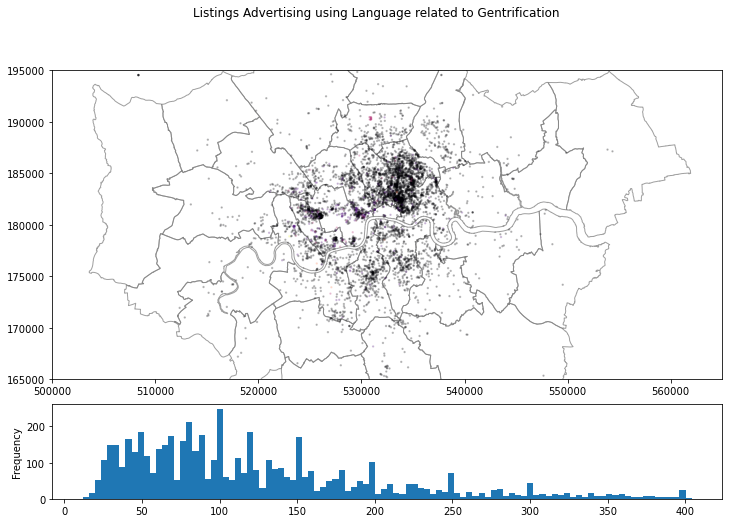

In [59]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
gent.plot(markersize=2, column='price', cmap='magma', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
gent[gent.price<gent.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("Listings Advertising using Language related to Gentrification")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

In [60]:
grouped_gent = gent.groupby('neighbourhood_cleansed')['price'].agg(Count='count')

In [61]:
grouped_gent.head(33).sort_values(by=['Count'], ascending=False)

,Count
neighbourhood_cleansed,
Hackney,1219
Tower Hamlets,716
Islington,515
Westminster,511
Southwark,443
Lambeth,368
Camden,340
Kensington and Chelsea,304
Wandsworth,202


In [62]:
gent.head(n=1)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,minimum_nights,maximum_nights,geometry
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,My very RECENTLY RENOVATED flat is located in ...,1481412,"London, United Kingdom",1,3,Tower Hamlets,51.53,-0.07,Entire rental unit,Entire home/apt,90.00,5,365,POINT (533682.377 182823.988)


In [63]:
# Airbnb listings within London Boroughs - Spatial subset
gent1 = gpd.sjoin(gent, boros, predicate = 'within')
gent1.head(n=1)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,...,price,minimum_nights,maximum_nights,geometry,index_right,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,My very RECENTLY RENOVATED flat is located in ...,1481412,"London, United Kingdom",1,3,Tower Hamlets,51.53,-0.07,...,90.00,5,365,POINT (533682.377 182823.988),26,Tower Hamlets,E09000030,"2,157.50",179.71,T


### Based on this regex, we can see that most airbnbs that use terms associated with gentrification in their description are located in Hackney.

## Spatial Autocorrelation of Gentrified Listings

### Data cleaning

In this part, we will only keep a few columns for analysis.

**First**, we will count the airbnb listings based on room types. The number of listings per borough will be standardised which would allow us for a comparison. Afterwards, PCA will be conducted to reduce the dimension of our room types.

**Second**, mean/median price of airbnb listings will be calculated which will be standardised as well

Once these procedures are completed, we will go on with spatial autocorrelation analysis.

In [64]:
# to group listings based on GSS_CODE,
# we need to merge our gentrification airbnb listings with London Shapefile

gent1.rename(columns = {'neighbourhood_cleansed' : 'borough'}, inplace = True)
boros.rename(columns = {'NAME' : 'borough'}, inplace = True)

gent2 = pd.merge(gent1, boros, how = 'left', on = 'borough')

In [65]:
# drop repeated column
gent2.drop(columns = ['NAME', 'GSS_CODE_x'], inplace =True)

In [66]:
gent2.rename(columns = {'GSS_CODE_y': 'GSS_CODE'}, inplace = True)

In [67]:
# Check room types

pivot = gent2.groupby(['GSS_CODE','room_type']
    
    # listing_url is an unique identifier and 
    # that is why we count number of rooms based on it
        ).host_id.agg(Count='count').reset_index().pivot(
    index='GSS_CODE', columns=['room_type'], values=['Count'])

# there is no null value in our new data and all columns in correct data types
pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, E09000001 to E09000033
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   (Count, Entire home/apt)  32 non-null     int64
 1   (Count, Hotel room)       32 non-null     int64
 2   (Count, Private room)     32 non-null     int64
 3   (Count, Shared room)      32 non-null     int64
dtypes: int64(4)
memory usage: 1.2+ KB


In [68]:
# We can check that Entire home/apt and Private room
# are predominant
pivot.sum()

       room_type      
Count  Entire home/apt    3926
       Hotel room           15
       Private room       1744
       Shared room          19
dtype: int64

In [69]:
# drop insignificant room_type

pivot.columns = ['Entire home/apt','Hotel room','Private room','Shared room']
pivot.drop(columns = ['Hotel room', 'Shared room'], inplace = True)

In [70]:
# normalise count of listings

pivot_norm = pd.DataFrame(index=pivot.index)
for c in pivot.columns.to_list():
    # Power Transform
    # count to normalised values
    pivot_norm[c] = pts.fit_transform(pivot[c].to_numpy().reshape(-1,1))

pivot_norm.head()

,Entire home/apt,Private room
GSS_CODE,,
E09000001,-0.01,-1.26
E09000002,-1.40,-0.61
E09000003,-0.25,-0.19
E09000004,-1.40,-1.26
E09000005,0.48,0.46


In [71]:
# We only have two columns in our pivot_norm
# And about 96% of these can be explained by pca component 1

pcomp = PCA(n_components= 2, random_state=42)
rd    = pcomp.fit_transform(pivot_norm)
print(f"The explained variance of each component is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")
explained_variance = pcomp.explained_variance_ratio_

The explained variance of each component is: 96.12%, 3.88%


In [72]:
# we are only choosing first component
# I just kept these 1 col

airbnb_pca = pd.DataFrame(
    # rescaling data with minmax scaler
    # as we are interested in the first PCA component,
    # we specify it with rd[:,0]
                {'2022_Airbnb Component 1': mms.fit_transform(rd[:,0].reshape(-1,1)).reshape(1,-1)[0]},
                index=pivot.index)



# In case, you want to keep two cols
#airbnb_pca = pd.DataFrame(
    # rescaling data with minmax scaler
 #               {'2019_Airbnb Component 1': mms.fit_transform(rd[:,0].reshape(-1,1)).reshape(1,-1)[0], 
  #              '2019_Airbnb Component 2': mms.fit_transform(rd[:,1].reshape(-1,1)).reshape(1,-1)[0]},
   #             index=pivot.index)

airbnb_pca.head()

,2022_Airbnb Component 1
GSS_CODE,
E09000001,-0.42
E09000002,-0.62
E09000003,-0.19
E09000004,-0.80
E09000005,0.20


In [73]:
# Add the airbnb_pca to the original gent1 file

# merge the data based on GSS_CODE
ldn_gss_idx = gent2.set_index('GSS_CODE')
rs = pd.merge(ldn_gss_idx, airbnb_pca, left_index=True, right_index = True)
len(rs)

5704

In [74]:
rs.head(n=5)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,borough,latitude,longitude,...,geometry_x,index_right,HECTARES_x,NONLD_AREA_x,ONS_INNER_x,HECTARES_y,NONLD_AREA_y,ONS_INNER_y,geometry_y,2022_Airbnb Component 1
GSS_CODE,,,,,,,,,,,,,,,,,,,,,
E09000001,482178,Central London St. Paul's and City Location,This listing is our own home and not a managed...,2176101,"London, United Kingdom",2,3,City of London,51.52,-0.10,...,POINT (532063.079 181701.113),32,314.94,24.55,T,314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",-0.42
E09000001,566957,Clerkenwell and City of London,This is a large 1 bedroom flat in the Barbican...,2788818,"London, United Kingdom",3,5,City of London,51.52,-0.10,...,POINT (532105.514 181777.885),32,314.94,24.55,T,314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",-0.42
E09000001,7754615,"Modern, zone 1, Central London",Beautiful refurbished central London apartment...,37213616,"London, United Kingdom",1,2,City of London,51.52,-0.11,...,POINT (531181.088 181363.349),32,314.94,24.55,T,314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",-0.42
E09000001,13218153,Cosy 2 bedroom Business flat @trendy Spitalfields,Cosy and quiet 2-bedroom/2 bathroom business f...,74140157,"London, United Kingdom",1,1,City of London,51.52,-0.08,...,POINT (533566.482 181370.963),32,314.94,24.55,T,314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",-0.42
E09000001,13488640,"Very central, 2 Bed flat in Barbican area.",My place is bright and cleaned to the recommen...,30103750,"England, United Kingdom",2,3,City of London,51.52,-0.09,...,POINT (532499.502 181950.611),32,314.94,24.55,T,314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",-0.42


In [75]:
# Create a new dataframe that contains
# GSS_CODE, PCA component1, geometry of each listing
new_gent = rs.reset_index().loc[:, ['GSS_CODE', '2022_Airbnb Component 1', 'geometry_x']].copy().set_index('GSS_CODE')


# Append median price from cleaned listings grouped by GSS_CODE
s1 = rs.groupby(by='GSS_CODE').price.agg('median')
# rescale median price by using minmaxscaler
new_gent['2022_median_price'] = pd.Series(np.squeeze(mms.fit_transform(s1.values.reshape(-1,1))), index=s1.index)

# Append mean price from cleaned listings grouped by GSS_CODE
s2 = rs.groupby(by='GSS_CODE').price.agg('mean')
# rescale mean price by using minmaxscaler
new_gent['2022_mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

new_gent.rename(columns = {'geometry_x': 'geometry'}, inplace = True)
new_gent= new_gent[['2022_Airbnb Component 1', '2022_median_price',
                   '2022_mean_price', 'geometry']]

new_gent.head(n=1)
# cldf is a merged numeric data of census tract and airbnb data
#s2 = cleaned.groupby(by='MSOA11CD').price.agg('mean')
#cldf['mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

#cldf.drop(columns=['Subregion','Borough'], inplace=True)

#cldf.head()

,2022_Airbnb Component 1,2022_median_price,2022_mean_price,geometry
GSS_CODE,,,,
E09000001,-0.42,1.00,-0.15,POINT (532063.079 181701.113)


## Local Moran's I

Steps we've taken until now:
- We have eliminated two insignificant room_types (hotel, shared room) based on their numbers.
- We have normalised our airbnb data using powertransformation.
- We have reduced our airbnb dimensions from 2 to 1. The representiveness of first PCA component is 96 %.
- We have rescaled average/median price by using minmaxcaler.

Steps to take:
- We have to calculate spatial lag of our variable of interest. As we are very much keen on the number of airbnb listings, we have to create a spatial lag of pca-version of airbnb listing count.

The codes are adjusted from [Spatial Autocorrelation Code](https://deepnote.com/@siew-sook-yan/Python-Global-and-Local-Morans-51c478c0-3b3a-42df-9aef-caff60da71f6).

### Packages

In [76]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pysal.viz import mapclassify
import pysal as ps
import numpy as np
import esda
from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
from esda.moran import Moran_Local
from giddy.directional import Rose
from pysal.lib import weights
import libpysal
import splot
from splot.giddy import dynamic_lisa_composite

In [77]:
new_gent

,2022_Airbnb Component 1,2022_median_price,2022_mean_price,geometry
GSS_CODE,,,,
E09000001,-0.42,1.00,-0.15,POINT (532063.079 181701.113)
E09000001,-0.42,1.00,-0.15,POINT (532105.514 181777.885)
E09000001,-0.42,1.00,-0.15,POINT (531181.088 181363.349)
E09000001,-0.42,1.00,-0.15,POINT (533566.482 181370.963)
E09000001,-0.42,1.00,-0.15,POINT (532499.502 181950.611)
...,...,...,...,...
E09000033,0.60,-0.02,-0.19,POINT (529725.024 181181.226)
E09000033,0.60,-0.02,-0.19,POINT (527202.367 181584.179)
E09000033,0.60,-0.02,-0.19,POINT (525299.686 181339.576)


In [78]:
new_gent.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5704 entries, E09000001 to E09000033
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   2022_Airbnb Component 1  5704 non-null   float64 
 1   2022_median_price        5704 non-null   float64 
 2   2022_mean_price          5704 non-null   float64 
 3   geometry                 5704 non-null   geometry
dtypes: float64(3), geometry(1)
memory usage: 351.9+ KB


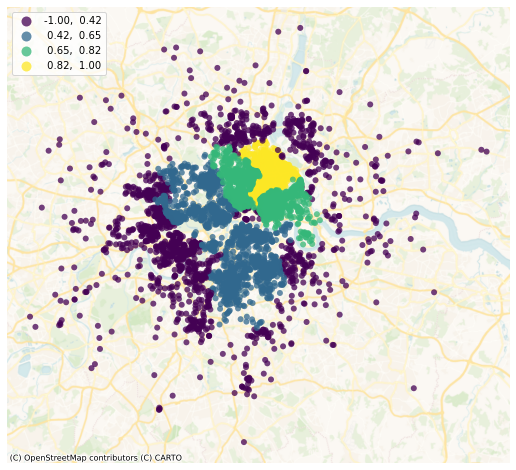

In [79]:
# Set up figure and a single axis
import contextily 


f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
new_gent.plot(
    column="2022_Airbnb Component 1",
    cmap="viridis",
    scheme="quantiles",
    k=4,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=new_gent.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

In [80]:
# 30 listings in one neighbourhood can be thought of a sign that
# might indicate gentrification
df = new_gent.reset_index()
knn8 = weights.KNN.from_dataframe(df, k = 30)


# Row-standardization
knn8.transform = 'r'


In [81]:
# Spatial lag of our airbnb listings
df["w_2022_Airbnb Component 1"] = weights.spatial_lag.lag_spatial(
    knn8, df["2022_Airbnb Component 1"]
)
df.head(n=3)

,GSS_CODE,2022_Airbnb Component 1,2022_median_price,2022_mean_price,geometry,w_2022_Airbnb Component 1
0,E09000001,-0.42,1.00,-0.15,POINT (532063.079 181701.113),0.42
1,E09000001,-0.42,1.00,-0.15,POINT (532105.514 181777.885),0.45
2,E09000001,-0.42,1.00,-0.15,POINT (531181.088 181363.349),0.15


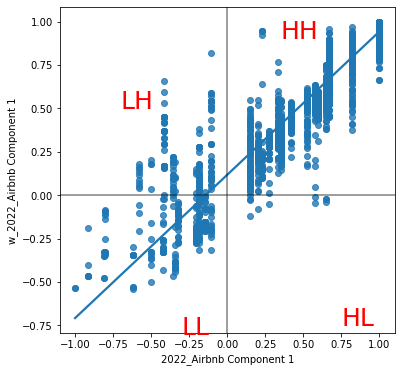

In [82]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x= "2022_Airbnb Component 1", y="w_2022_Airbnb Component 1", data=df, ci=None
);

# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(0.35, 0.9, "HH", fontsize=25, c="r")
plt.text(0.75, -0.75, "HL", fontsize=25, c="r")
plt.text(-0.7, 0.5, "LH", fontsize=25, c="r")
plt.text(-0.3, -0.8, "LL", fontsize=25, c="r")
# Display
plt.show()

Using standardized values, we can immediately divide each variable 

The airbnb pca component, and its spatial lag in two groups: 

those with above-average airbnb listings, which have positive standardized values;


those with below-average airbnb listings, which have negative standardized values;

In [83]:
# Local Moran's I
lisa_22 = esda.Moran_Local(df['2022_Airbnb Component 1'], knn8, seed = 42)

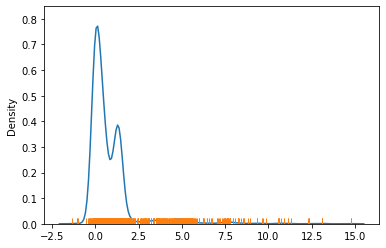

In [84]:
# Draw KDE line
ax = sns.kdeplot(lisa_22.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa_22.Is, ax=ax);

The firgure shows a positively skewed distribution of local Moran'I statistics.

This indicates that most of Moran's I statistics values are positive.

Hence, we need to bear in mind that the high positive values arise from value similarity in space.

This can be due to either high values being next to high values or low values next to low values.

In other words, **Positive Autocorrelation**

But local Moran's I cannot distinguish which one it is between two.

### Choropleth plots of local Moran's I

In [85]:
# package
from splot import esda as esdaplot

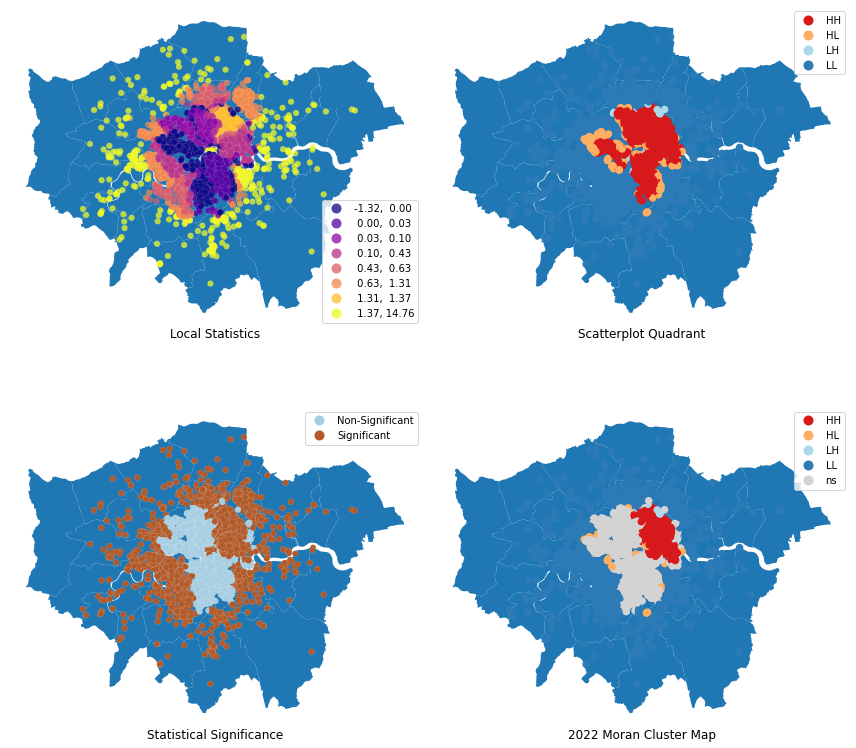

In [86]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# London borough map
boros.plot(ax = ax)
# Assign new column with local statistics on-the-fly
df.assign(
    Is=lisa_22.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=8,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)


# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# London borough map
boros.plot(ax = ax)
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa_22, df, p=1, ax=ax)


# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
# London borough map
boros.plot(ax = ax)
# Find out significant observations
labels = pd.Series(
    1 * (lisa_22.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=df.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
df.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=8,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)




# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# London borough map
boros.plot(ax = ax)
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_22, df, p=0.05, ax=ax)



# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "2022 Moran Cluster Map",
        ][i],
        y=-0.05,
    )
    

# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

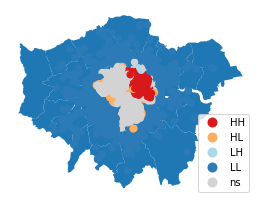

In [87]:
# Set up figure and axes
fig, ax1 = plt.subplots(figsize=(5, 3.5))
# London borough map
boros.plot(ax = ax1)
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_22, df, p=0.05, ax=ax1)
plt.show()

### Insight

The yellow and purple in the map on the upper left side display the largest magnitudes which can be either high or low values.

The map on the lower right corner shows the location of the LISA statistic in the quadrant of the Moran Scatter plot. These red-coloured boroughs are Hackney, Tower Hamlets and Islington. 

In [88]:
# count quadrant
# 1 means High-High quadrant
# 2 means Low-High quadrant
# 3 means Low-Low quadrant
# 4 means High-Low quadrant
counts = pd.value_counts(lisa_22.q)
counts

1    3144
3    2245
4     259
2      56
dtype: int64

### Insight
- HH (1) and LL (3) values are predominant.
- First two maps simply mapped the raw LISA value alongside the quadrant in which the local statistic resides. However, it didn't take into account statistical significance.
- The cluster map includes significance information alongside the quadrant and local statistic. Together, this map extracts significant observations -those that are highly unlikely to have come from pure chance- and plots them with a specific color depending on their quadrant category.

In [89]:
# Statistically significant lisa statistics
(lisa_22.p_sim < 0.05).sum() * 100 / len(lisa_22.p_sim)

63.49929873772791

Nearly two-thirds of polygons that have degrees of local spatial association strong enough to reject the idea of pure chance.

We can identify high densities of plausible gentrification going on in East London on Moran Cluster Map.


In [90]:
# Assign pseudo P-values to `df`
df["p-sim"] = lisa_22.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa_22.p_sim < 0.05)
# Assign significance flag to `db`
df["sig"] = sig

In [91]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa_22.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}

# Create column in `db` with labels for each polygon
df["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=df.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)

df.head(n=1)

,GSS_CODE,2022_Airbnb Component 1,2022_median_price,2022_mean_price,geometry,w_2022_Airbnb Component 1,p-sim,sig,labels
0,E09000001,-0.42,1.00,-0.15,POINT (532063.079 181701.113),0.42,0.01,1,LL


In [92]:
len(df)

5704

In [93]:
# Filter HH and HL as they could be related to gentrification?
probable_gent = df.loc[(df['labels'] == 'HH') | (df['labels'] == 'HL') |
                              (df['labels'] == 'LH')]

In [94]:
probable_gent.GSS_CODE.value_counts()

E09000012    1217
E09000030     686
E09000019     109
E09000028      20
E09000033      19
E09000031       4
E09000014       2
E09000025       1
Name: GSS_CODE, dtype: int64

### Interpretation of Local Moran's I
- Areas labelled as HL or LH can be thought of boroughs under gentrification threats.
- Areas labelled as HH are already highly gentrified.
- Hackney, Tower Hamlets and Islington were top 3 boroughs with respect to gentrification
- HH are places where airbnbs are already densely gentrified
- HL means high values are surrounded by low values so this might tell us that some areas are under airbnb's expansion.
- LH means low values are surrounded by high values so we could think these are the areas under gentrification?

### Exporting Files
Here, I export the listings as geofeather to make them more useable (read take up less memory). However, for each, I will remove the geometry because that is not preserved in the process of writing to a feather

In [95]:
# #all cleaned listings
# geo_listings2022.drop(axis=1, columns=['geometry']).to_feather('full_2022listingsclean')

In [96]:
#all cleaned listings for this dataset (specific fields)
gl22.drop(axis=1, columns=['geometry'])
gl22.to_feather('listings22')

In [97]:
#gentrification listings
gent.drop(axis=1,columns=['geometry'])
gent.to_feather('listings22_gentrification')

In [98]:
#kc listings
kc.drop(axis=1,columns=['geometry'])
kc.to_feather('listings22_kensington_chelsea')

In [99]:
#camden listings
Camden.drop(axis=1,columns=['geometry'])
Camden.to_feather('listings22_camden')

In [100]:
#hackney listings
hack.drop(axis=1, columns=['geometry'])
hack.to_feather('listings22_hackney')